In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn import preprocessing
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Audio Process

In [ ]:
Tess = '/content/drive/MyDrive/Tess/'

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for file in tess_directory_list:
  file = file.split('.')[0]
  part = file.split('_')[2]
  if part=='ps':
    file_emotion.append('surprise')
  else:
    file_emotion.append(part)
  file_path.append(Tess + file +'.wav')
       
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
#print(Tess_df)

In [ ]:
data_path=Tess_df
#data_path.to_csv("data_path.csv",index=False)
data_path.head()
num1=len(data_path)
print(num1)

2800


In [ ]:
data_path=data_path.dropna(axis=0,how='any')
num2=len(data_path)
print(num2)

2800


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


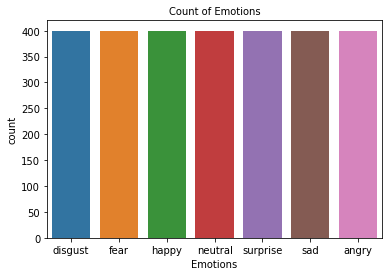

In [ ]:
plt.title('Count of Emotions', size=10)
sns.countplot(data_path.Emotions)

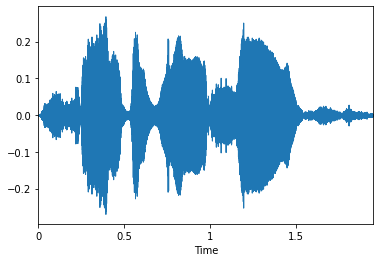

In [ ]:
# 
emotion='fear'

data_agg=np.array(data_path.Path[data_path.Emotions==emotion])[1]

data, sampling_rate = librosa.load(data_agg)
librosa.display.waveplot(data,sampling_rate)

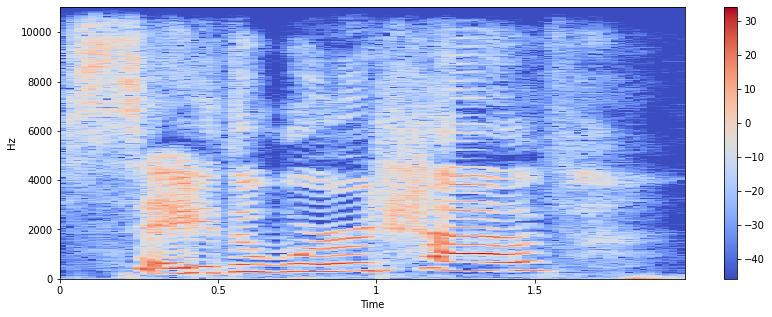

In [ ]:
# 
data,sampling_rate = librosa.load(data_agg)
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(np.abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
Audio(data_agg)

# Audio Augmentation

In [ ]:
# function ploting the spectrogram and time series

def plot_spec(data,sr):
  fig,ax=plt.subplots(1,2,figsize=(15,5))
  ax[0].specgram(data,Fs=sr)
  ax[1].set_ylabel('amplitude')
  ax[1].plot(np.linspace(0,1,len(data)),data)

In [ ]:
# noise addition

import IPython.display as ipd
def noise(data):
  data_nois=data+np.random.normal(0,0.02,len(data))
  return data_nois

In [ ]:
# wave shifting

def shift(data,sampling_rate):
  data_shift=np.roll(data,int(sampling_rate/2))
  return data_shift

In [ ]:
# stretch

def stretch(data,factor=0.8):
  data_stch = librosa.effects.time_stretch(data,factor)
  return data_stch

In [ ]:
def pitch(data,sampling_rate,n_steps=-5):
  data_pitch_sf = librosa.effects.pitch_shift(data,sampling_rate,n_steps)
  ipd.Audio(data=data_pitch_sf,rate=sampling_rate)
  return data_pitch_sf

# Feature Extraction

In [ ]:
def extract_features(data,sampling_rate):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    return result

In [ ]:
def get_features(path):
  data,sampling_rate=librosa.load(path,duration=2.5,offset=0.6)
  data=noise(data)
  data=shift(data,sampling_rate)
  data=stretch(data)
  data=pitch(data,sampling_rate)
  result=extract_features(data,sampling_rate)
  return result

In [ ]:
# Since it takes a lot of time, we will just load the saved file
'''
X, Y = [], []
i=0
for path in data_path.iloc():
    i=i+1
    emotion=path.Emotions
    path=path.Path
    result=get_features(path)
    X.append(result)
    Y.append(emotion)
'''

'\nX, Y = [], []\ni=0\nfor path in data_path.iloc():\n    i=i+1\n    emotion=path.Emotions\n    path=path.Path\n    result=get_features(path)\n    X.append(result)\n    Y.append(emotion)\n'

In [ ]:
# we save the features here
'''
df_data=pd.DataFrame(X)
df_label=pd.DataFrame(Y)
df_feature=pd.concat([df_data,df_label],axis=1,ignore_index=True)
print(df_feature)
path='/content/drive/MyDrive/Tess_features.csv'
df_feature.to_csv(path, index=False)
'''

"\ndf_data=pd.DataFrame(X)\ndf_label=pd.DataFrame(Y)\ndf_feature=pd.concat([df_data,df_label],axis=1,ignore_index=True)\nprint(df_feature)\npath='/content/drive/MyDrive/Tess_features.csv'\ndf_feature.to_csv(path, index=False)\n"

In [ ]:
# here we load the saved feature
path='/content/drive/MyDrive/Tess_features.csv'
Features=pd.read_csv(path)
print(Features)

               0          1          2  ...         18         19        20
0    -244.922295  73.201085 -54.617660  ...   8.054605  -6.809167      fear
1    -253.592593  69.795732 -48.101579  ...   9.288153  -7.593563     happy
2    -265.891405  74.301385 -49.612307  ...  10.180001  -9.351969   neutral
3    -272.694351  76.008938 -56.306525  ...  13.877015 -10.452168  surprise
4    -266.587051  71.440468 -38.636318  ...   8.062694 -10.823622       sad
...          ...        ...        ...  ...        ...        ...       ...
2795 -290.139818  76.989742 -66.095520  ...  14.016958 -12.813644       sad
2796 -274.769583  77.706962 -51.060224  ...  10.427747 -12.230986   disgust
2797 -267.630164  81.407868 -55.218562  ...  11.912350 -10.278751     angry
2798 -269.849384  74.810563 -50.252701  ...   5.640058 -16.082448      fear
2799 -281.512799  85.855602 -58.553018  ...  10.772715 -13.968915     happy

[2800 rows x 21 columns]


In [ ]:
# a function that divides the dataset into train, test and validation
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(Features)

In [ ]:
x_train=train.iloc[:, 0:-1].values
y_train=train.iloc[:, 20].values
x_dev=validate.iloc[:, 0:-1].values
y_dev=validate.iloc[:, 20].values
x_test=test.iloc[:, 0:-1].values
y_test=test.iloc[:, 20].values

In [ ]:
# onehot of label
encoder = OneHotEncoder()
y_train = encoder.fit(np.array(y_train).reshape(-1,1)).transform(np.array(y_train).reshape(-1,1)).toarray()
y_dev = encoder.transform(np.array(y_dev).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(y_test).reshape(-1,1)).toarray()

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_dev.shape, y_dev.shape

((1680, 20), (1680, 7), (560, 20), (560, 7), (560, 20), (560, 7))

In [ ]:
# scale the features
X = Features.iloc[:, 0:-1].values
scaler = StandardScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_dev = scaler.transform(x_dev)

In [ ]:
model = Sequential()

model.add(Conv1D(256, 8, padding='same', activation="relu",input_shape=(x_train.shape[1],1))) 
model.add(MaxPooling1D(pool_size=(4)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv1D(256, 8, padding='same', activation="relu")) 
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv1D(256, 8, padding='same', activation="relu")) 
model.add(MaxPooling1D(pool_size=(1)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv1D(256, 8, padding='same', activation="relu")) 
model.add(MaxPooling1D(pool_size=(1)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

#model.add(Flatten())

model.add(layers.LSTM(256))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(7)) 
model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer="Adam",loss="binary_crossentropy",metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 256)           2304      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 256)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 batch_normalization (BatchN  (None, 5, 256)           1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 256)            524544    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 256)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_dev, y_dev), callbacks=[rlrp])

Epoch 1/50
27/27 [==============================] - 12s 36ms/step - loss: 0.5683 - accuracy: 0.2607 - val_loss: 0.5949 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 0s 13ms/step - loss: 0.3944 - accuracy: 0.4268 - val_loss: 0.4730 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 0s 11ms/step - loss: 0.2917 - accuracy: 0.5673 - val_loss: 0.4029 - val_accuracy: 0.2464 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 0s 11ms/step - loss: 0.2258 - accuracy: 0.6661 - val_loss: 0.4021 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 0s 12ms/step - loss: 0.2038 - accuracy: 0.6935 - val_loss: 0.3810 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 0s 11ms/step - loss: 0.1966 - accuracy: 0.7048 - val_loss: 0.3899 - val_accuracy: 0.3643 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 0s 11ms/step - loss: 0.

18/18 [==============================] - 0s 4ms/step - loss: 0.2160 - accuracy: 0.8018
Accuracy of our model on test data :  80.17857074737549 %


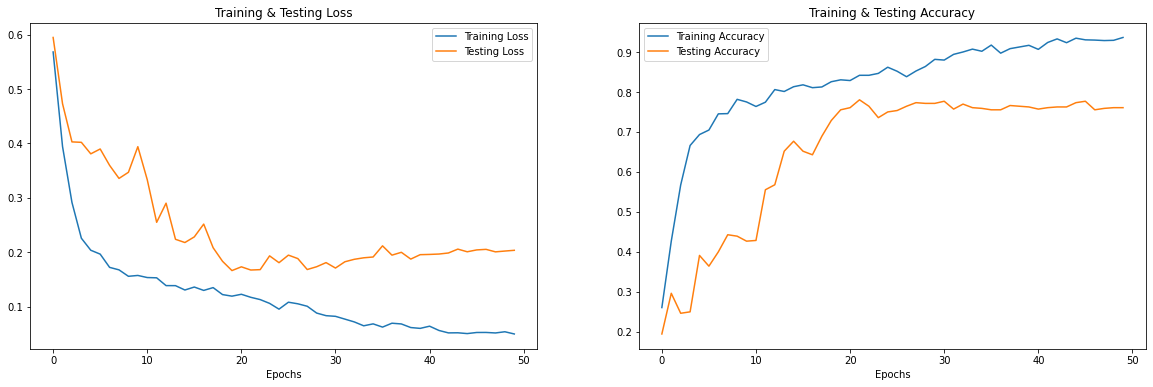

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Facial Expression

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
#from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from sklearn import preprocessin
import random

In [ ]:
datapath = '/content/drive/MyDrive/facial_expression/fer2013 (1).csv'
df=pd.read_csv(datapath)

In [ ]:
df.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
x_train = []
y_train = []
x_dev = []
y_dev = []
x_test = []
y_test = []
testcase = df[df['Usage']=='PrivateTest']
for row in df.iloc:
  if (row[2] == 'Training'):
    x_train.append([float(i)/255.0 for i in row[1].split()])
    y_train.append(row[0])
  elif (row[2] == 'PublicTest'):
    x_dev.append([float(i)/255.0 for i in row[1].split()])
    y_dev.append(row[0])
  else:
    x_test.append([float(i)/255.0 for i in row[1].split()])
    y_test.append(row[0])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_dev = np.array(x_dev)
y_dev = np.array(y_dev)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train)
print(y_train)

[[0.2745098  0.31372549 0.32156863 ... 0.41568627 0.42745098 0.32156863]
 [0.59215686 0.58823529 0.57647059 ... 0.75686275 0.71764706 0.72156863]
 [0.90588235 0.83137255 0.61176471 ... 0.34509804 0.43137255 0.59607843]
 ...
 [0.29019608 0.31764706 0.34117647 ... 0.7372549  0.73333333 0.73333333]
 [0.87058824 0.89019608 0.79607843 ... 0.53333333 0.53333333 0.5254902 ]
 [0.76470588 0.78039216 0.80392157 ... 0.02352941 0.05882353 0.14901961]]
[0 0 2 ... 4 0 4]


In [ ]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_dev = x_dev.reshape(x_dev.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

In [ ]:
# one hot encoding
onehot = preprocessing.OneHotEncoder()
y_test = onehot.fit(y_test.reshape(-1, 1)).transform(y_test.reshape(-1, 1)).toarray()
y_dev = onehot.transform(y_dev.reshape(-1, 1)).toarray()
y_train = onehot.transform(y_train.reshape(-1, 1)).toarray()
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [ ]:
# construct the model
f_model = tf.keras.Sequential([
  Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=[48, 48, 1]),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Conv2D(256, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Conv2D(512, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),

  Flatten(),

  Dense(512, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),

  Dense(128, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),

  Dense(7, activation='softmax')
])

In [ ]:
f_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 24, 24, 128)     

In [ ]:
f_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystop_callback = EarlyStopping(monitor='accuracy', min_delta=0.05, patience=5)
history = f_model.fit(x_train, y_train, batch_size=64, epochs=30, callbacks=[earlystop_callback], validation_data=(x_dev, y_dev))

Epoch 1/30
449/449 [==============================] - 8s 14ms/step - loss: 1.8198 - accuracy: 0.3107 - val_loss: 2.2611 - val_accuracy: 0.1931
Epoch 2/30
449/449 [==============================] - 6s 14ms/step - loss: 1.3876 - accuracy: 0.4696 - val_loss: 1.4869 - val_accuracy: 0.4152
Epoch 3/30
449/449 [==============================] - 6s 14ms/step - loss: 1.2193 - accuracy: 0.5365 - val_loss: 1.2527 - val_accuracy: 0.5208
Epoch 4/30
449/449 [==============================] - 6s 14ms/step - loss: 1.1318 - accuracy: 0.5734 - val_loss: 1.2789 - val_accuracy: 0.5183
Epoch 5/30
449/449 [==============================] - 6s 14ms/step - loss: 1.0585 - accuracy: 0.6001 - val_loss: 1.1034 - val_accuracy: 0.5790
Epoch 6/30
449/449 [==============================] - 6s 14ms/step - loss: 0.9876 - accuracy: 0.6293 - val_loss: 1.1447 - val_accuracy: 0.5726
Epoch 7/30
449/449 [==============================] - 6s 14ms/step - loss: 0.9243 - accuracy: 0.6537 - val_loss: 1.1151 - val_accuracy: 0.5740

In [ ]:
f_model.evaluate(x_test, y_test)

113/113 [==============================] - 1s 4ms/step - loss: 1.6086 - accuracy: 0.6322


[1.608617901802063, 0.6322095394134521]

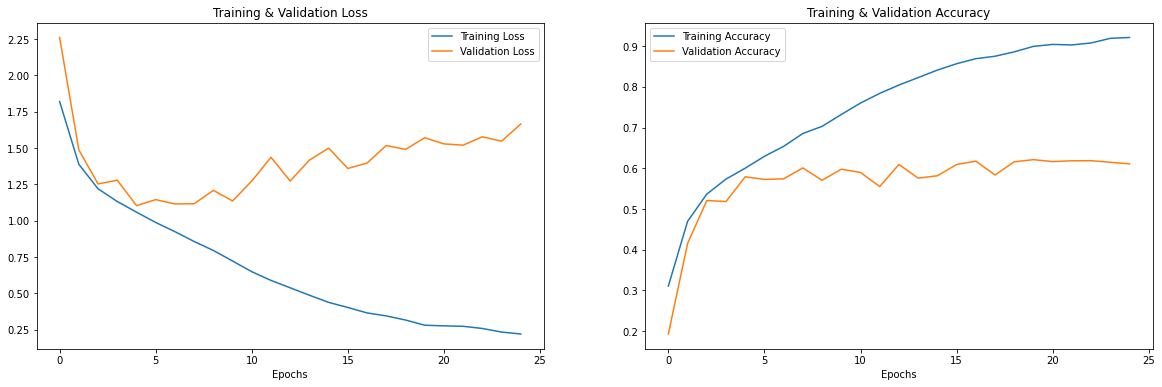

In [ ]:
epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Combine Audio and Facial Expression

In [ ]:
# get the prediction information of the facial expression
y_pred = f_model.predict(x_test)
pred_label = [] # index of emotion
pred_emotion = [] # string of emotion
emotion = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
for i in y_pred:
  t = 0.0
  idx = 0
  for j in range(0, len(i)):
    if (i[j] > t):
      t = i[j]
      idx = j
  pred_label.append(idx)
  pred_emotion.append(emotion[idx])

In [ ]:
# tranform the pixels into the information that can be used to plot
test_image = []
for row in testcase.iloc:
  test_image.append(np.array([float(i)/255.0 for i in row[1].split()]).reshape(48, 48))

In [ ]:
# add prediction information and plot information to the testcase dataframe
testcase.insert(testcase.shape[1], 'pred_label', pred_label)
testcase.insert(testcase.shape[1], 'pred_emotion', pred_emotion)
testcase.insert(testcase.shape[1], 'pic_array', test_image)
testcase.head(10)

,emotion,pixels,Usage,pred_label,pred_emotion,pic_array
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest,0,Angry,"[[0.6666666666666666, 0.4627450980392157, 0.39..."
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest,0,Angry,"[[0.027450980392156862, 0.0196078431372549, 0...."
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest,0,Angry,"[[0.9098039215686274, 0.9411764705882353, 0.94..."
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest,4,Sad,"[[0.7843137254901961, 0.7725490196078432, 0.58..."
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest,2,Fear,"[[0.1568627450980392, 0.10980392156862745, 0.1..."
32303,0,138 142 66 80 87 92 97 99 88 73 72 83 92 102 1...,PrivateTest,0,Angry,"[[0.5411764705882353, 0.5568627450980392, 0.25..."
32304,4,72 66 66 69 62 51 57 60 56 66 63 70 68 68 81 9...,PrivateTest,6,Neutral,"[[0.2823529411764706, 0.25882352941176473, 0.2..."
32305,3,4 4 7 12 14 18 26 31 33 38 44 49 59 68 80 86 9...,PrivateTest,3,Happy,"[[0.01568627450980392, 0.01568627450980392, 0...."
32306,0,245 245 239 122 144 101 33 37 84 137 143 130 1...,PrivateTest,2,Fear,"[[0.9607843137254902, 0.9607843137254902, 0.93..."
32307,3,20 31 65 81 79 63 61 51 61 97 114 121 140 200 ...,PrivateTest,3,Happy,"[[0.0784313725490196, 0.12156862745098039, 0.2..."


In [ ]:
# randomly choose an audio to predict
import random
#print(data_path)
random_num=random.randint(0,2429)
#print(random_num)
random_path=data_path.Path[random_num]
print(random_path)
Audio(random_path)

/content/drive/MyDrive/Tess/YAF_rain_happy.wav


The predicted emotion is:  Happy


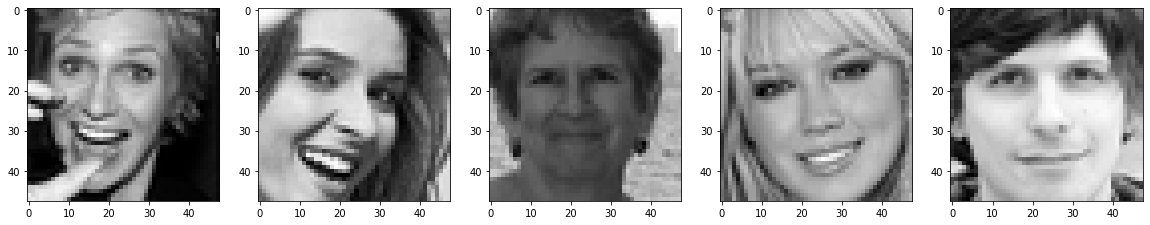

In [ ]:
# output 5 corresponding facial expressions
def plot_facial_expression(emotion):
  temp = testcase[testcase['pred_emotion'] == emotion]  # get the dataframe of the corresponding emotions from the prediction
  row_num = random.randint(0, temp.shape[0] - 5)    # randomly choose the starting row to plot
  plt.figure(figsize=(20, 12))
  for i in range(0, 5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(temp.iloc[row_num + i][5], cmap='gray')

df_test_feature=get_features(random_path)
df_test_feature=pd.DataFrame(df_test_feature)
#print(df_test_feature)
df_test_feature.shape
df_test=df_test_feature.T
df_test = scaler.transform(df_test)
df_test = np.expand_dims(df_test, axis=2)
pred_test = model.predict(df_test)

y_pred_aud = encoder.inverse_transform(pred_test)

y_pred_au=y_pred_aud.tolist()
for i in y_pred_au:
  aud_emotion=str(str(i)[2:-2].capitalize())
print('The predicted emotion is: ', aud_emotion)
plot_facial_expression(aud_emotion)